## Using Remote Sensing to Predict and Understand Future Wildfires
### by Zeynep Ankut, Isaiah Stene, Corey Becker

Does the needed imports and downloads the dataset (takes like 5 minutes)

In [94]:
import importFunctions as imp 
import kagglehub

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
print("Path to dataset files:", path)

train_files = path + "/next_day_wildfire_spread_train*"
test_files = path + "/next_day_wildfire_spread_test*"
eval_files = path + "/next_day_wildfire_spread_eval*"


train = imp.get_dataset(train_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


eval_data = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

Path to dataset files: C:\Users\theco\.cache\kagglehub\datasets\fantineh\next-day-wildfire-spread\versions\2


In [95]:
def plotRows(start,end,titles,n_features,data):
  inputs, labels = next(iter(data))

  fig = plt.figure(figsize=(15,6.5))

  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  n_rows = end-start
  for i in range(n_rows):
    for j in range(n_features + 1):
      plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
      if i == 0:
        plt.title(titles[j], fontsize=13)
      if j < n_features - 1:
        plt.imshow(inputs[i+start, :, :, j], cmap='viridis')
      if j == n_features - 1:
        plt.imshow(inputs[i+start, :, :, -1], cmap=CMAP, norm=NORM)
      if j == n_features:
        plt.imshow(labels[i+start, :, :, 0], cmap=CMAP, norm=NORM) 
      plt.axis('off')
  plt.tight_layout()

  plt.show()

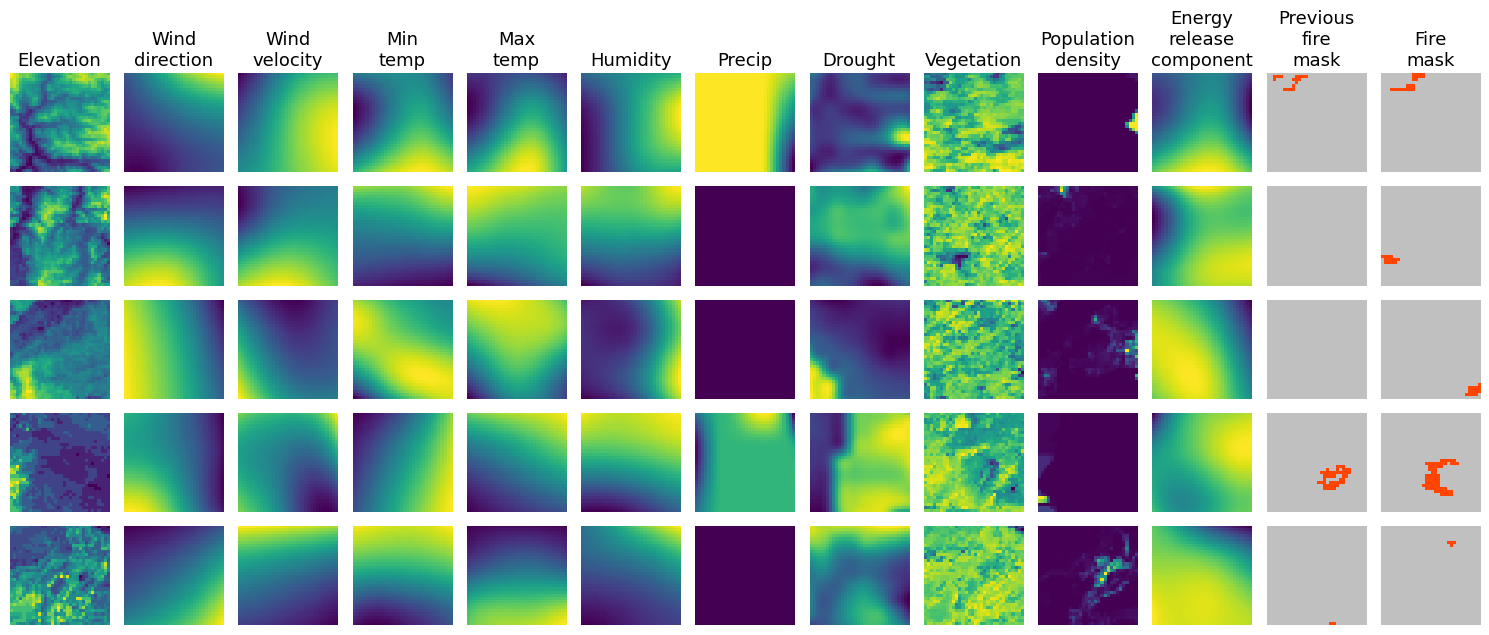

In [96]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

plotRows(20,25,titles,len(titles)-1, train)

In [97]:
inputs, labels = next(iter(train))


#now get select features
indices = [1, 2, 3, 4, 5, 6, 10]
tf.gather(inputs, indices, axis=-1)

# # print(labels.shape)

# n_fires, height,width, feat_images = inputs.shape

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, feat_images)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(3)) # there are 3 outputs: fire, no fire, and no data

# model.summary()

<tf.Tensor: shape=(100, 32, 32, 7), dtype=float32, numpy=
array([[[[ 2.68534943e+02,  3.71338797e+00,  2.80762512e+02, ...,
           6.48681074e-03,  0.00000000e+00,  3.81931038e+01],
         [ 2.68155670e+02,  3.72703290e+00,  2.80786621e+02, ...,
           6.48203492e-03,  0.00000000e+00,  3.82867584e+01],
         [ 2.67788055e+02,  3.74073648e+00,  2.80810333e+02, ...,
           6.47721766e-03,  0.00000000e+00,  3.83813858e+01],
         ...,
         [ 2.76658905e+02,  4.04250717e+00,  2.80756104e+02, ...,
           6.26529334e-03,  0.00000000e+00,  4.05220184e+01],
         [ 2.76986633e+02,  4.05169153e+00,  2.80740784e+02, ...,
           6.25948049e-03,  0.00000000e+00,  4.05617523e+01],
         [ 2.77239563e+02,  4.06098700e+00,  2.80725098e+02, ...,
           6.25441736e-03,  0.00000000e+00,  4.05936813e+01]],

        [[ 2.68856842e+02,  3.72462940e+00,  2.80776031e+02, ...,
           6.48508826e-03,  0.00000000e+00,  3.81932068e+01],
         [ 2.68475494e+02,  3.

In [98]:


def build_segmentation_cnn(height,width, features, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, features)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(num_classes, (1, 1), activation='softmax')
    ])
    return model

def shift_data(labels):
    return tf.maximum(labels,tf.constant([0.]))
        
  

def masked_loss(y_true, y_pred):
    """Compute loss while ignoring -1 values."""
    y_true = tf.squeeze(y_true, axis=-1)  # Remove extra dimension
    mask = tf.not_equal(y_true, -1)  # Mask for valid labels
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')(y_true, y_pred)
    return tf.reduce_mean(tf.boolean_mask(loss, mask))


In [99]:
n_fires, height,width, feat_images = inputs.shape

model = build_segmentation_cnn(height,width,feat_images,2)

labels = shift_data(labels)


c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [100]:

t_inputs, t_labels = next(iter(test))
e_inputs, e_labels = next(iter(eval_data))

t_labels = shift_data(t_labels)
e_labels = shift_data(e_labels)

tf.gather(t_inputs, indices, axis=-1)
tf.gather(e_inputs, indices, axis=-1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(inputs, labels, epochs=10, 
                    validation_data=(e_inputs, e_labels))


Epoch 1/10


c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 749ms/step - accuracy: 0.4990 - loss: 0.9427 - val_accuracy: 0.9578 - val_loss: 0.1847
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.5588 - loss: 0.7898 - val_accuracy: 0.9176 - val_loss: 0.3623
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.5130 - loss: 0.7109 - val_accuracy: 0.4137 - val_loss: 0.7856
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.6848 - loss: 0.6557 - val_accuracy: 0.4807 - val_loss: 0.7950
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.7061 - loss: 0.5970 - val_accuracy: 0.6179 - val_loss: 0.5453
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.8130 - loss: 0.5546 - val_accuracy: 0.9272 - val_loss: 0.4343
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.8883 - loss: 0.5222 - val_accuracy: 0.6176 - val_loss: 0.6244
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.9373 - loss: 0.4946 - val_accuracy: 0.9381 - val_loss: 0.4375
Epo

4/4 - 0s - 62ms/step - accuracy: 0.9633 - loss: 0.4262
0.9632617235183716


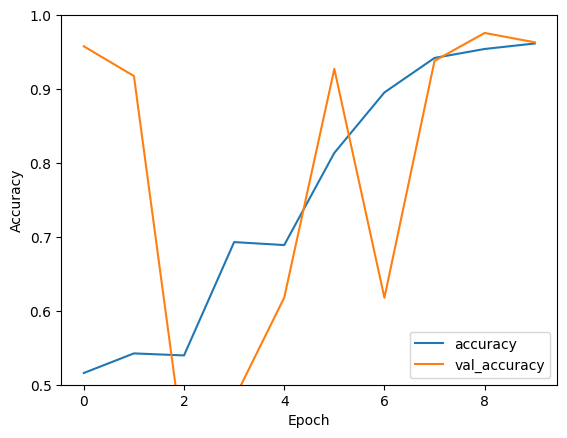

In [103]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(e_inputs,  e_labels, verbose=2)

print(test_acc)

NEXT STEP: CHECK PREDICTIONS WITH PLOTS AND IMAGES! why is the accuaracy bad :(